$$
\begin{aligned}
C_{ij} =\ & A_{ij} \\
&+ A_{ik} (I - A_{lk})^{-1} A_{lj} \\
&+ A_{il} (I - A_{kl})^{-1} A_{kj} \\
&+ A_{ik} (I - A_{lk})^{-1} A_{lk} (I - A_{kl})^{-1} A_{kj} \\
&+ A_{il} (I - A_{kl})^{-1} A_{kl} (I - A_{lk})^{-1} A_{lj}
\end{aligned}
$$

In [ ]:
import jax.numpy as jnp
from jax.numpy.linalg import pinv

def permutation_xxpp_to_xpxp(num_modes):
    """Returns permutation matrix P to convert from xxpp to xpxp ordering"""
    n = 2 * num_modes
    P = jnp.zeros((n, n))
    for i in range(num_modes):
        P = P.at[2*i, i].set(1)         # x_i
        P = P.at[2*i + 1, i + num_modes].set(1)  # p_i
    return P

def xxpp_to_xpxp(A):
    P = permutation_xxpp_to_xpxp(A.shape[0]//2)
    return P @ A @ P.T

def realify(A):
    return jnp.block([[A.real, A.imag], [-A.imag, A.real]])

def interconnect_s(A, k, l):
    A = jnp.asarray(A)
    N = A.shape[0] // 2

    x = jnp.arange(N)
    # Create mask that is True if x is NOT equal to a or b
    mask = (x != k) & (x != l)
    ext_ports = x[mask]

    C = jnp.zeros((2*N - 4, 2*N - 4))
    for m in range(C.shape[0]//2):
        i = ext_ports[m].item()
        for n in range(C.shape[0]//2):
            j = ext_ports[n].item()
            term_0 = A[2*i:2*(i+1), 2*j:2*(j+1)]
            term_1 = A[2*i:2*(i+1), 2*k:2*(k+1)] @ pinv(jnp.eye(2)-A[2*l:2*(l+1), 2*k:2*(k+1)]) @ A[2*l:2*(l+1), 2*j:2*(j+1)]
            term_2 = A[2*i:2*(i+1), 2*l:2*(l+1)] @ pinv(jnp.eye(2)-A[2*k:2*(k+1), 2*l:2*(l+1)]) @ A[2*k:2*(k+1), 2*j:2*(j+1)]
            term_3 = A[2*i:2*(i+1), 2*k:2*(k+1)] @ pinv(jnp.eye(2)-A[2*l:2*(l+1), 2*k:2*(k+1)]) @ A[2*l:2*(l+1), 2*k:2*(k+1)] @ pinv(jnp.eye(2)-A[2*k:2*(k+1), 2*l:2*(l+1)])@A[2*k:2*(k+1), 2*j:2*(j+1)]
            term_4 = A[2*i:2*(i+1), 2*l:2*(l+1)] @ pinv(jnp.eye(2)-A[2*k:2*(k+1), 2*l:2*(l+1)]) @ A[2*k:2*(k+1), 2*l:2*(l+1)] @ pinv(jnp.eye(2)-A[2*l:2*(l+1), 2*k:2*(k+1)])@A[2*l:2*(l+1), 2*j:2*(j+1)]
            C = C.at[2*m:2*(m+1), 2*n:2*(n+1)].set(C[2*m:2*(m+1), 2*n:2*(n+1)] + term_0 + term_1 + term_2 + term_3 + term_4)
            pass
    
    return C
    
    


     0    1    2    3    4    5    6    7
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
6  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
     0    1    2    3
0  0.0  0.0  1.0  0.0
1  0.0  0.0  0.0  1.0
2  1.0  0.0  0.0  0.0
3  0.0  1.0  0.0  0.0


In [ ]:
import scipy
import numpy as np
import pandas as pd
phi_a = 0 * np.pi / 180
phi_b = 0 * np.pi / 180

S_a = np.exp(1j * phi_a) * np.array([[0j, 1],[1, 0j]])
S_b = np.exp(1j * phi_b) * np.array([[0j, 1],[1, 0j]])
S = scipy.linalg.block_diag(S_a, S_b)
F = xxpp_to_xpxp(realify(S))

F_new = interconnect_s(F, 1, 2)

print(pd.DataFrame(F))
print(pd.DataFrame(F_new))

     0    1    2    3         4         5         6         7
0  0.0  0.0  1.0  0.0  0.000000  0.000000  0.000000  0.000000
1  0.0  0.0  0.0  1.0  0.000000  0.000000  0.000000  0.000000
2  1.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000
3  0.0  1.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000
4  0.0  0.0  0.0  0.0  0.000000  0.000000  0.866025  0.500000
5  0.0  0.0  0.0  0.0  0.000000  0.000000 -0.500000  0.866025
6  0.0  0.0  0.0  0.0  0.866025  0.500000  0.000000  0.000000
7  0.0  0.0  0.0  0.0 -0.500000  0.866025  0.000000  0.000000
          0         1         2         3
0  0.000000  0.000000  0.866025  0.500000
1  0.000000  0.000000 -0.500000  0.866025
2  0.866025  0.500000  0.000000  0.000000
3 -0.500000  0.866025  0.000000  0.000000


/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/skrf/mathFunctions.py:268: RuntimeWarning: divide by zero encountered in log10
  out = 20 * np.log10(z)


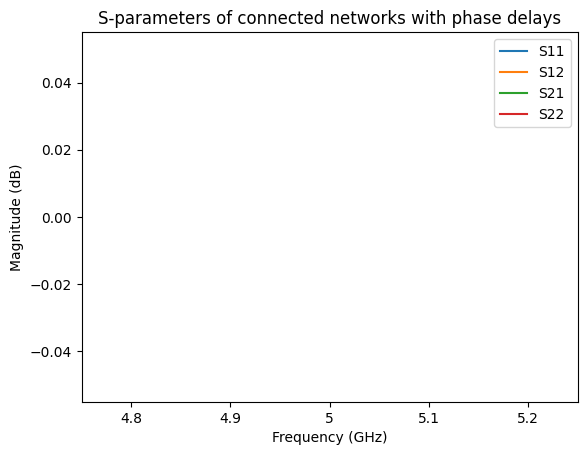

Combined S-matrix:
 [[0.       +0.j  0.8660254+0.5j]
 [0.8660254+0.5j 0.       +0.j ]]


In [1]:
import skrf as rf


# Single frequency at 5 GHz
freq = rf.Frequency(5, 5, 1, unit='GHz')

# Define phases
phi_a = 0 * np.pi / 180
phi_b = 30 * np.pi / 180

# Define S-matrices (2-port delay lines with phase shifts)
S_a = np.exp(1j * phi_a) * np.array([[0j, 1],
                                     [1, 0j]])
S_b = np.exp(1j * phi_b) * np.array([[0j, 1],
                                     [1, 0j]])

# Wrap into 3D arrays for single frequency (shape: 1 x 2 x 2)
S_a = S_a[np.newaxis, :, :]
S_b = S_b[np.newaxis, :, :]

# Create Networks
net_a = rf.Network(s=S_a, frequency=freq)
net_b = rf.Network(s=S_b, frequency=freq)

# Connect port 1 of net_a to port 0 of net_b
# The resulting network has ports: net_a port 0 and net_b port 1
combined = rf.connect(net_a, 1, net_b, 0)

# Plot the combined network S-parameters in dB
combined.plot_s_db()
plt.title("S-parameters of connected networks with phase delays")
plt.show()

# Print combined S-matrix at the frequency
print("Combined S-matrix:\n", combined.s[0])


In [ ]:
import numpy as np
import scipy
import pandas as pd

import numpy as np

def permutation_matrix(connections, num_ports_a, num_ports_b):
    N = num_ports_a + num_ports_b
    internal_ports = set()
    for a_port, b_port in connections:
        internal_ports.add(a_port)
        internal_ports.add(num_ports_a + b_port)
    
    external_ports = [p for p in range(N) if p not in internal_ports]
    internal_ports = sorted(internal_ports)
    
    new_order = external_ports + internal_ports
    P = np.zeros((N, N), dtype=int)
    for new_idx, old_idx in enumerate(new_order):
        # P[new_idx, old_idx] = 1
        P[old_idx, new_idx] = 1
    return P


phi_a = 0 * np.pi/180
phi_b = 30 * np.pi/180

S_a = np.exp(1j*phi_a)*np.array([[0j, 1], [1, 0j]])
S_b = np.exp(1j*phi_b)*np.array([[0j, 1], [1, 0j]])

S = scipy.linalg.block_diag(S_a, S_b)
connections = [(1, 0)]
num_ports_a = 2
num_ports_b = 2
P = permutation_matrix(connections, num_ports_a, num_ports_b)
num_internal_ports = 2*len(connections)
num_external_ports = num_ports_a + num_ports_b - num_internal_ports

S_prime = P.T@S@P

e = num_external_ports
i = num_internal_ports

S_ee = S_prime[:e, :e]
S_ei = S_prime[:e, e:e+i]
S_ie = S_prime[e:e+i, :e]
S_ii = S_prime[e:e+i, e:e+i]

# S_ei = np.array([[1j, 0j], [0j, 0]])
# S_ie = np.array([[1j, 0j], [1j, 0j]])
# S_ii = np.array([[0j, 0j], [0j, 0]])
print(pd.DataFrame(S))
print(pd.DataFrame(S_prime))

S_new = S_ee + S_ei @ np.linalg.inv(np.eye(S_ii.shape[0]) - S_ii)@S_ie
print(S_new)

                    0                   1                   2  \
0  0.000000+0.000000j  0.866025+0.500000j  0.000000+0.000000j   
1  0.866025+0.500000j  0.000000+0.000000j  0.000000+0.000000j   
2  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
3  0.000000+0.000000j  0.000000+0.000000j  0.866025+0.500000j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2  0.866025+0.500000j  
3  0.000000+0.000000j  
                    0                   1                   2  \
0  0.000000+0.000000j  0.000000+0.000000j  0.866025+0.500000j   
1  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
2  0.866025+0.500000j  0.000000+0.000000j  0.000000+0.000000j   
3  0.000000+0.000000j  0.866025+0.500000j  0.000000+0.000000j   

                    3  
0  0.000000+0.000000j  
1  0.866025+0.500000j  
2  0.000000+0.000000j  
3  0.000000+0.000000j  
[[0.5+0.8660254j 0. +0.j       ]
 [0. +0.j        0.5+0.8660254j]]


In [241]:
S_ee

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

# Math Aside
We can find the inverse if the sum on the right converges.
$$
(I-T)^{-1} = \sum_{k=0}^{\infty}T^k
$$

In [176]:
from scipy.linalg import eig
import numpy as np

phi = np.pi
transmittivity = 1.0

F_phi = np.array([
    [np.cos(phi), -np.sin(phi)],
    [np.sin(phi), np.cos(phi)],
])

# Compute eigenvalues and right eigenvectors
eigenvalues, eigenvectors = eig(np.sqrt(1-transmittivity)*F_phi)

print("Eigenvalues:", eigenvalues)
F_phi

Eigenvalues: [0.+0.j 0.+0.j]


array([[-1.0000000e+00, -1.2246468e-16],
       [ 1.2246468e-16, -1.0000000e+00]])

In [177]:
F_prime = transmittivity*F_phi@np.linalg.inv(np.eye(2)+np.sqrt(1-transmittivity)*F_phi)+np.sqrt(1-transmittivity)*np.eye(2)

print(F_prime)
# np.angle(F_prime@np.array([1, 0])[0] + 1j*F_prime@np.array([1, 0])[1])
out_real = F_prime@np.array([1, 0])
out_complex = out_real[0] + 1j*out_real[1]
np.angle(out_complex)*180/np.pi

F_prime

[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]


array([[-1.0000000e+00, -1.2246468e-16],
       [ 1.2246468e-16, -1.0000000e+00]])

In [172]:
np.linalg.pinv(np.zeros((2, 2)))

array([[0., 0.],
       [0., 0.]])

In [163]:
out = F_prime @ np.array([1, 0])
out_complex = out[0] + 1j*out[1]
np.angle(out_complex)*180/np.pi

np.float64(179.99999999999997)

# Sagnac Example
$$
\begin{align*}
\hat{a}_1 &\rightarrow \sqrt{\eta} \, \hat{a}_1 + \sqrt{1 - \eta} \, \hat{a}_2 \\
\hat{a}_2 &\rightarrow -\sqrt{1 - \eta} \, \hat{a}_1 + \sqrt{\eta} \, \hat{a}_2
\end{align*}
$$

$$
\begin{equation*}
\begin{pmatrix}
\hat{a}_1' \\
\hat{a}_2'
\end{pmatrix}
=
\begin{pmatrix}
\sqrt{\eta} & \sqrt{1 - \eta} \\
-\sqrt{1 - \eta} & \sqrt{\eta}
\end{pmatrix}
\begin{pmatrix}
\hat{a}_1 \\
\hat{a}_2
\end{pmatrix}
\end{equation*}
$$

\begin{equation*}
F_{\text{BS}} =
\begin{pmatrix}
\sqrt{\eta} & 0 & \sqrt{1 - \eta} & 0 \\
0 & \sqrt{\eta} & 0 & \sqrt{1 - \eta} \\
-\sqrt{1 - \eta} & 0 & \sqrt{\eta} & 0 \\
0 & -\sqrt{1 - \eta} & 0 & \sqrt{\eta}
\end{pmatrix}
\end{equation*}
